# ML Pipeline

My goals for this dataset was to extract meaningful features and classify the flight.

## Model Selection

### Supervised vs Unsuperivsed Learning

The first question I asked myself was should I use supervised or unsupervised techinques. To a large extent I like the certaininty of supervised techinque. There are verifiable model metrics that explicitly inform of me my success or failure. But would slapping on some labled really help me understand the true nature of the data? Below is my thought process:

Key Advantages of Supervised Learning:

- Results are directly interpretable since each class has a known real-world meaning
- Can leverage existing domain expertise through the labeling process
- Performance can be quantitatively validated against ground truth

Key Advantages of Unsupervised Learning:

- Can discover novel patterns that weren't previously known or considered
- Can analyze the complete dataset without being limited by label availability
- Not limited by the potential quality issues or obtuseness of labels

An unsupervised learning approach lets the data tell its own story. Rather than forcing the data into predefined boxes, we're letting the model make its own findings, discovering the true nature of contend of the data in ADSB records.

### Model Selection

Having decided to use unsupervised techinques, I now needed to choose which one(s). I really wanted something that would detect subtle variations in flight traces and that would not only be able to truly process high level data aggregations. At the same time, I want something that was performant or at least could be well optimized given the right hardware. My first priority though was really getting choosing a model that would get into the data, and if the outputs would be that much better I would be willing to make some performance trade-offs. Even though this is an academic project, I always keep model performance in mind because I want to get the most experience possible with models that make sense to deploy on real world problems ata production scale.

Here were the options I considered:

Traditional Machine Learning Models

- Traditional Clustering (K-means/DBSCAN)
  - Pros:
    - Computationally efficient and easy to implement
    - Very interpretable results with clear cluster centroids
    - Minimal hyperparameter tuning needed compared to deep learning approaches
  - Cons:
    - Cannot naturally handle temporal aspects of flight data
    - Struggles with variable-density clusters of flight patterns
    - No inherent mechanism for anomaly detection
- Isolation Forest
  - Pros:
  - Specifically designed for anomaly detection
    - Computationally efficient even with large datasets
    - Works well with high-dimensional flight data
  - Cons:
    - No clustering capability for normal flight patterns
    - Cannot capture temporal relationships in data
    - Limited interpretability of why something is classified as anomalous

Probabilistic Models 

- Hidden Markov Models (HMMs)
  - Pros:
    - Naturally models flight phase transitions
    - Computationally efficient once trained
    - Very interpretable state transitions
  - Cons:
    - Struggles with continuous, high-dimensional flight data
    - Limited ability to detect subtle anomalies
    - Can be biased by initial state assumptions

Deep Learning Models

- Autoencoder + HDBSCAN
  - Pros:
    - Simultaneously learns normal flight patterns while providing rich anomaly detection through reconstruction error
    - Produces interpretable latent space representations that help explain both clusters and anomalies
    - Can detect both global pattern deviations and local anomalies (like sudden accelerations) in a single model
  - Cons:
    - Requires significant tuning of both autoencoder architecture and HDBSCAN parameters
    - May overfit to common flight patterns if training data isn't sufficiently diverse
    - Computationally intensive during training phase compared to traditional methods

- GANs
  - Pros:
    - Can learn very subtle deviations from normal flight patterns
    - Particularly good at handling multimodal distributions in flight behaviors
    - Can generate synthetic examples to help validate anomaly detection
  - Cons:
    - Notoriously difficult to train and achieve stable convergence
  - Much higher computational overhead than other approaches
    - May suffer from mode collapse, missing important but rare flight patterns

- LSTM-based approaches
  - Pros:
    - Naturally handles temporal dependencies in flight patterns
    - Excellent at predicting expected behavior sequences
    - Can capture long-term dependencies in flight phases
  - Cons:
    - Tends to focus on global patterns, potentially missing local anomalies
    - Memory requirements scale with sequence length
    - Can be biased toward more common flight patterns, potentially normalizing subtle anomalies

Although it would probably be interesting to apply all of the models listed above, the becase of the scope of this project (and the fact that I sank so much time extracting and trandorming the data) we are only gong to choose one... and we're going with the Autoencoder + HDBSCAN combination because it uniquely provides both rich anomaly detection capabilities through reconstruction error and effective clustering of normal flight patterns in a single model architecture, while maintaining interpretability through its latent space representations. This approach outperforms other models by simultaneously capturing both global flight patterns and local anomalies (such as unusual accelerations or trajectory deviations), and though it requires more computational resources during training, the quality of insights it provides justifies this tradeoff compared to simpler approaches.

### Tools used

Before going into the individual models, let's take a look at the core packages doing the work here and talk about why we chose them.

- Core Machine Learning Tools:
  - PyTorch:
    - Implements autoencoder architecture for dimensionality reduction of flight data
    - Provides GPU acceleration for training through CUDA integration
    - Manages batch processing and gradient optimization through DataLoader
    - Generally easier implementation and tuning than Tensorflow for simliar models

  - HDBSCAN:
    - Performs density-based clustering to identify distinct flight patterns
    - Handles noise points and variable-density clusters automatically
    - Determines optimal number of clusters through hierarchical density estimation

  - Scikit-learn:
    - Standardizes features through robust scaling operations
    - Removes outliers using statistical methods (z-score analysis)
    - Provides consistent preprocessing pipeline for both training and inference

- Data Management Tools:
  - SQLAlchemy + psycopg2:
    - Handles efficient batch retrieval of flight telemetry data
    - Maintains connection pooling for concurrent database operations
    - Provides ORM interface for complex flight data queries

  - Pandas:
    - Processes time-series flight data through vectorized operations
    - Manages complex feature engineering for altitude and speed metrics
    - Handles missing data and temporal alignment of flight records

In [19]:
# import dependencies 
import pandas as pd
from IPython.display import display, HTML  
from IPython.display import Image
import IPython.core.getipython as getipython
import json
import sys
import torch
from torch.serialization import add_safe_globals

# import model object
sys.path.append('../scripts')
from _09_autoencoder_training import Autoencoder

# Add Autoencoder to safe globals
add_safe_globals([Autoencoder])

In [17]:
import plotly.graph_objects as go
import plotly.io as pio

def create_plot():
    # Create figure
    fig = go.Figure(data=go.Scatter(x=[1, 2, 3, 4], y=[10, 11, 12, 13]))
    
    fig.update_layout(title='Test Plot', 
                     xaxis_title='X Axis',
                     yaxis_title='Y Axis')
    
    # Save as static PNG
    fig.write_image("test_plot.png")
    
    # Show interactive version in VSCode
    fig.show()

# Run the function
create_plot()

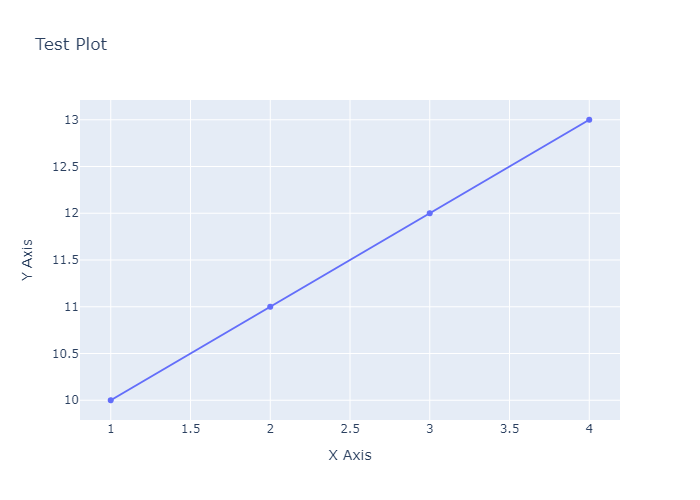

In [20]:
Image("test_plot.png")

### Hyperparmeter Selection

#### Autoencoder

Hyperparemeters chosen:

- Encoding Dimension (10)
  - Implements 3:1 compression ratio from ~30 input features
  - Forces autoencoder to learn salient flight patterns while discarding noise
  - Provides sufficient dimensions to encode standard flight phases while retaining capacity for pattern variations
 
- Batch Size (32) 
  - Optimizes GPU memory utilization within 12GB constraint
  - Maintains training stability through adequate batch size
  - Ensures sufficient sample diversity for flight pattern capture
 
- Network Width Progression (32 → 16 → 10)
  - Initial width accommodates ~30 dimensional input space
  - Progressive halving prevents information bottlenecks
  - Creates efficient information funnel for dimensionality reduction
 
- Epochs (50)
  - Appropriate iteration count for 100k sample dataset
  - Achieves convergence within 10 minute training window
  - Balances pattern learning against overfitting risk given architecture simplicity

Potential options for future research:

- Encoding Dimension (currently 10)
  - Try values: [8, 12, 15]
  - Higher dimensions could capture more nuanced flight patterns
  - Still maintains efficient compression ratio (2:1 at maximum)
  - Worth testing first as most impactful parameter

- Network Width Progression (currently 32 → 16 → 10)
  - Try values: [64 → 32 → 10] or [48 → 24 → 10]
  - Wider initial layers capture more complex feature interactions
  - GPU memory constraints allow for this expansion
  - Maintains gradual dimensionality reduction principle

- Batch Size (currently 32)
  - Try values: [64, 128]
  - 100k samples and 12GB GPU enable larger batches
  - Could improve training stability
  - May speed up convergence

- Epochs (currently 50)
  - Try values: [75, 100]
  - Sub-10-minute training allows for more iterations
  - Should be tuned last after other parameters
  - Monitor validation loss to prevent overfitting



In [2]:
# Load the model
model_path = '../data/_09_autoencoder_training/model.pth'
loaded_autoencoder = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
loaded_autoencoder.eval()

print("=== Basic Model Information ===")
print(f"Model Type: {type(loaded_autoencoder).__name__}")
print(f"Model Mode: {'Training' if loaded_autoencoder.training else 'Evaluation'}")

print("\n=== Architecture Overview ===")
print("Encoder Architecture:")
print(loaded_autoencoder.encoder)
print("\nDecoder Architecture:")
print(loaded_autoencoder.decoder)

print("\n=== Dimensionality Analysis ===")
# Get input/encoding dimensions from the first and last layer of encoder
input_dim = next(loaded_autoencoder.encoder.children()).in_features
encoding_dim = list(loaded_autoencoder.encoder.children())[-2].out_features  # -2 to skip ReLU
print(f"Input Dimension: {input_dim}")
print(f"Encoding Dimension: {encoding_dim}")
print(f"Compression Ratio: {input_dim/encoding_dim:.1f}x")

print("\n=== Parameter Analysis ===")
# Separate encoder and decoder parameters
encoder_params = sum(p.numel() for p in loaded_autoencoder.encoder.parameters())
decoder_params = sum(p.numel() for p in loaded_autoencoder.decoder.parameters())
total_params = encoder_params + decoder_params

print(f"Encoder Parameters: {encoder_params:,}")
print(f"Decoder Parameters: {decoder_params:,}")
print(f"Total Parameters: {total_params:,}")

print("\n=== Layer Details ===")
for name, param in loaded_autoencoder.state_dict().items():
    if isinstance(param, torch.Tensor):
        print(f"\nLayer: {name}")
        print(f"Shape: {list(param.size())}")
        print(f"Parameters: {param.numel():,}")
        print(f"Data Type: {param.dtype}")
        # Add basic statistics for weight matrices
        if 'weight' in name:
            print(f"Weight Stats:")
            print(f"  Mean: {param.mean().item():.4f}")
            print(f"  Std: {param.std().item():.4f}")
            print(f"  Min: {param.min().item():.4f}")
            print(f"  Max: {param.max().item():.4f}")

print("\n=== Hardware Information ===")
devices = set(param.device for param in loaded_autoencoder.parameters())
print(f"Model Device(s): {devices}")

=== Basic Model Information ===
Model Type: Autoencoder
Model Mode: Evaluation

=== Architecture Overview ===
Encoder Architecture:
Sequential(
  (0): Linear(in_features=450, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
)

Decoder Architecture:
Sequential(
  (0): Linear(in_features=32, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=450, bias=True)
)

=== Dimensionality Analysis ===
Input Dimension: 450
Encoding Dimension: 32
Compression Ratio: 14.1x

=== Parameter Analysis ===
Encoder Parameters: 158,688
Decoder Parameters: 159,106
Total Parameters: 317,794

=== Layer Details ===

Layer: en

In [3]:
# Add this after loading the model
for name, param in loaded_autoencoder.named_parameters():
    if torch.isnan(param).any():
        print(f"Found NaN in {name}")
        print(f"Number of NaN values: {torch.isnan(param).sum().item()}")

In [4]:
#### Examine outputs

# read in sample data
df = pd.read_parquet('../data/_09_autoencoder_training/results.parquet')

print(f"number of rows: {len(df)}")

display(df.head())

number of rows: 1000000


,time_offset_0,vertical_rate_0,ground_speed_0,heading_0,altitude_0,vertical_accel_0,ground_accel_0,turn_rate_0,climb_descent_accel_0,time_offset_1,...,time_offset_49,vertical_rate_49,ground_speed_49,heading_49,altitude_49,vertical_accel_49,ground_accel_49,turn_rate_49,climb_descent_accel_49,segment_id
0,0.021274,-2391.272217,426.204803,256.997345,26619.986328,-26.189440,0.015159,0.608051,-103.790306,9.001877e+06,...,400537216.0,-1286.003540,311.033478,280.729126,11123.783203,-0.198297,-0.271256,0.385261,17.207180,8776640
1,-0.027585,1309.264160,429.967102,16.964352,21088.099609,41.075996,-0.209062,0.446521,-16.958027,1.199074e+07,...,750325632.0,-928.983521,456.485596,-3.226900,21995.623047,21.134535,0.320871,0.253475,-171.810287,9406275
2,0.010562,1091.447266,189.254166,222.599243,-3218.409912,22.040821,0.470975,0.090995,-63.672363,1.804085e+06,...,148401136.0,1923.508545,256.459290,215.714081,8521.358398,-7.209484,-0.086521,-0.333846,-47.320778,9304767
3,-0.000463,95.263321,462.243134,155.262802,34844.378906,-25.224617,-0.066722,0.203521,26.105040,1.976829e+07,...,806281152.0,-296.389709,454.934967,145.074097,32942.191406,-17.680965,-0.037470,-0.131092,-71.101250,8865567
4,0.010340,36.086594,98.401344,8.072521,1492.007935,-9.836600,-0.388105,0.385285,10.416059,1.311079e+07,...,431435712.0,-88.692192,92.438080,128.219528,1321.861450,-11.151931,0.025553,0.035737,-127.268661,11002401


#### HDBScan

Hyperparameters Chosen

- Min Cluster Size (100)
  - Currently represents ~0.1% of total dataset (100k samples)
  - Initial choice targeted approximately 10 clusters
  - Consider increasing to 250-500 for more robust clusters
  - Larger clusters would better represent major flight patterns
  
- Min Samples (5)
  - Conservative choice for noise detection
  - Sufficient for statistical significance without being too restrictive
  - Appropriate for normalized 10-dimensional space
  - Balances between noise sensitivity and cluster stability

- Epsilon (0.1)
  - Suitable for normalized data in 10-dimensional space
  - Conservative choice for allowing cluster expansion
  - Works well with normalized autoencoder outputs
  - Prevents excessive cluster merging

- Euclidean Distance (metric choice)
  - Natural choice for normalized, continuous flight data
  - Performs well in moderate-dimensional spaces (10D)
  - Computationally efficient for large datasets
  - Intuitive distance measure for spatial patterns

- EOM Cluster Selection
  - Better than leaf for handling varying density clusters
  - Well-suited for flight patterns that may have different densities
  - More robust to noise than alternative methods
  - Good at finding clusters of varying sizes

Potential options for future research:

- Min Cluster Size (currently 100)
  - Try values: [250, 500, 750]
  - Larger clusters would better represent major flight patterns
  - Could reduce noise sensitivity
  - May identify more stable, interpretable patterns

- Min Samples (currently 5)
  - Keep as is
  - Well-tuned for current implementation
  - Change only if noise sensitivity needs adjustment

- Epsilon (currently 0.1)
  - Keep as is
  - Works well with normalized data
  - Change only if cluster boundaries need adjustment

- Alternative Metrics to Consider
  - Cosine similarity for direction-based patterns
  - Manhattan distance for computational efficiency
  - Keep Euclidean as baseline

In [5]:
import pickle
import numpy as np

# Load the pickled model
with open('../data/_10_clustering/model.pkl', 'rb') as f:
    clusterer = pickle.load(f)

# Basic model info
print(f"Model Type: {type(clusterer).__name__}")
print(f"Min Cluster Size: {clusterer.min_cluster_size}")
print(f"Cluster Selection Method: {clusterer.cluster_selection_method}")

# Clustering results
n_clusters = len(np.unique(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
print(f"\nNumber of clusters: {n_clusters}")
print(f"Number of noise points: {np.sum(clusterer.labels_ == -1)}")
print(f"Total points: {len(clusterer.labels_)}")

# Cluster sizes
for label in np.unique(clusterer.labels_[clusterer.labels_ != -1]):
    print(f"\nCluster {label} size: {np.sum(clusterer.labels_ == label)}")

Model Type: HDBSCAN
Min Cluster Size: 10
Cluster Selection Method: eom

Number of clusters: 20
Number of noise points: 337
Total points: 860

Cluster 0 size: 15

Cluster 1 size: 41

Cluster 2 size: 29

Cluster 3 size: 33

Cluster 4 size: 17

Cluster 5 size: 27

Cluster 6 size: 13

Cluster 7 size: 10

Cluster 8 size: 14

Cluster 9 size: 20

Cluster 10 size: 30

Cluster 11 size: 15

Cluster 12 size: 25

Cluster 13 size: 16

Cluster 14 size: 11

Cluster 15 size: 18

Cluster 16 size: 15

Cluster 17 size: 11

Cluster 18 size: 36

Cluster 19 size: 127


In [6]:
#### Examine outputs

# read in sample data
df = pd.read_parquet('../data/_10_clustering/results.parquet').set_index('segment_id')

print(f"number of rows: {len(df)}")

display(df.head())


number of rows: 21399


,cluster,is_most_typical,is_most_extreme
segment_id,,,
10648263,0,False,False
9437118,-1,False,False
10669532,0,False,False
10601579,0,False,False
11968445,0,False,False
